# Scenario analysis - creating a line plot

The ability to examine relationships between system parameters and system variables is a powerful capability offered by the Dispatch API. This notebook outlines a workflow that can be used to perform ex-post scenario analyses using historical case file data. While the following sections examine how changes to demand forecasts would likely influences prices in a given region, the same principles can be applied to examine other relationships.

## Imports and authentication

In [1]:
import os
import json

import requests
import xmltodict
import matplotlib.pyplot as plt
from jsonpath_ng import jsonpath
from jsonpath_ng.ext import parse

# Base URL endpoint for the Dispatch API
base_url = 'http://nemde-api-host:8080/api/v1/'

## Load case file
We need some data to work with, so let's proceed by downloading a case file.

In [2]:
def convert_casefile(path_to_file):
    """Load a historical NEMDE case file and convert it to a dict"""

    # Read case file contents
    with open(path_to_file, 'r') as f:
        casefile = f.read()

    # Force these nodes to always return lists
    force_list = ('Trade', 'TradeTypePriceStructure',)

    return xmltodict.parse(casefile, force_list=force_list)


def load_casefile(case_id):
    """Load case file"""
    
    # Load case file and convert to JSON
    casefile = convert_casefile(f'../../data/NEMSPDOutputs_{case_id}00.loaded')
   
    return casefile

# Load case file
case_id = '20210401001'
casefile = load_casefile(case_id=case_id)

## Approach
It is always a good idea to separate data from logic. Let's treat the case file that we saved to disk as our canonical 'source of truth', with this 'base' case file loaded before performing each update. As this case file will never be overwritten we can be sure we're using the same data before making updates, thus reducing the possibilty of introducing unintended changes.

The following function reads the base case file from disk then updates the Demand Forecast (`@DF`) parameter for South Australia. This allows us to investigate how prices respond to changes in anticipated demand.

In [3]:
def update_region_demand_forecast(case_id, region_id, value):
    """Load case file and update demand forecast for a given region"""
    
    # Load case file
    load_casefile(case_id=case_id)

    # Construct expression
    expression = (f"NEMSPDCaseFile \
                  .NemSpdInputs \
                  .PeriodCollection \
                  .Period \
                  .RegionPeriodCollection \
                  .RegionPeriod[?(@RegionID=='{region_id}')] \
                  .@DF")

    # Construct JSON path expression
    jsonpath_expr = parse(expression)

    # Update value
    _ = jsonpath_expr.update(casefile, value)
    
    return casefile

Jobs are submitted to the online queue, with each job having a different `@DF` value. Job IDs will be used to map `@DF` parameters to results once they are available.

In [4]:
def submit_jobs(base_url, region_id, values):
    """Submit jobs to online queue"""
    
    jobs = []
    for i in values:
        # Construct request body - using augmented casefiles
        body = {"casefile": update_region_demand_forecast(case_id='20210401001', region_id=region_id, value=i)}

        # Submit request and extract job ID
        url = base_url + 'jobs/create'
        response = requests.post(url=url, json=body)
        job_info = response.json()

        # Construct a map between the job ID, job info and the value of the parameter used in the analysis
        jobs.append({'job_info': job_info, 'demand_forecast': i})

    return jobs

# Demand forecast parameters
values = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
jobs = submit_jobs(base_url=base_url, region_id='SA1', values=values)

We can check the status of all our jobs by using the following endpoint:

`http://nemde-api-host/api/v1/jobs/status/list`

In [5]:
def get_status(base_url):
    """Get status of all jobs"""

    url = base_url + 'jobs/status/list'
    response = requests.get(url=url)
    status = response.json()
    
    return status


# Get job status list
status = get_status(base_url=base_url)

# Only printing the first three jobs (to save space)
status[:3]    

[{'job_id': '774da812-739b-4dad-aeae-b3211d011863',
  'status': 'finished',
  'created_at': '2021-08-07T14:03:45.044224Z',
  'enqueued_at': '2021-08-07T14:03:45.221426Z',
  'started_at': '2021-08-07T14:05:55.521917Z',
  'ended_at': '2021-08-07T14:06:46.836269Z',
  'timeout': '180',
  'label': None},
 {'job_id': '77ce2242-2fc7-47d2-abfe-b314e27e275a',
  'status': 'finished',
  'created_at': '2021-08-07T14:03:42.545729Z',
  'enqueued_at': '2021-08-07T14:03:42.707600Z',
  'started_at': '2021-08-07T14:05:54.574736Z',
  'ended_at': '2021-08-07T14:06:48.632590Z',
  'timeout': '180',
  'label': None},
 {'job_id': 'e8a0778f-efc8-41d9-93f5-ba14050e3fb6',
  'status': 'finished',
  'created_at': '2021-08-07T14:03:40.214655Z',
  'enqueued_at': '2021-08-07T14:03:40.394830Z',
  'started_at': '2021-08-07T14:05:08.473547Z',
  'ended_at': '2021-08-07T14:05:59.321272Z',
  'timeout': '180',
  'label': None}]

## Retrieve results
Once the jobs have finished their results can be retrieved from the queue.

In [6]:
def get_job_results(base_url, job_ids):
    """Get job results"""
    
    results = []
    for job_id in job_ids:
        # Construct URL used to obtain results
        url = base_url + f'jobs/{job_id}/results'
        print("Job results URL:", url)

        # Submit request and retrieve job results
        response = requests.get(url=url)
        results.append(response.json())
        
    return results


# Get all job IDs for which results should be returned
job_ids = [i.get('job_info').get('job_id') for i in jobs]

# Retrieve job results from queue
job_results = get_job_results(base_url=base_url, job_ids=job_ids)

Job results URL: http://nemde-api-host:8080/api/v1/jobs/666977c2-8a78-4638-8918-2025ee351ec4/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/a912dc3c-0442-4124-8748-e6297b4fdcfb/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/cb2d578b-ba38-4476-8a1c-149eae2d0adc/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/24ba0574-00c2-4ebd-8a27-499a51c32abc/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/7130a5e6-b42a-4919-8649-fcc015e15105/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/367d793c-4eb3-43eb-8194-23aadea70c6a/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/09c6be74-f033-4661-a53f-af2d8c1d0094/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/9cea60f0-e9b2-4dc2-84fb-03c917a00bcc/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/e8a0778f-efc8-41d9-93f5-ba14050e3fb6/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/77ce2242-2fc7-47d2-abfe-b314e27e275

The following function searches a results dictionary for the energy price corresponding to a given region. This will allow us to examine how the energy price changes as the `@DF` parameter is augmented.

In [7]:
def get_region_energy_price(results, region_id):
    """Extract energy price from results dictionary"""
    
    expression = (f"results \
                  .output \
                  .RegionSolution[?(@RegionID='{region_id}')] \
                  .@EnergyPrice")

    jsonpath_expr = parse(expression)   
    values = [match.value for match in jsonpath_expr.find(results)]
    
    # Only one value should be returned
    if len(values) != 1:
        msg = f"Should only return 1 value, encountered: {len(values)} {region_id}"
        raise Exception(msg)

    return values[0]

Job IDs are used to map Demand Forecast parameters to price outcomes.

In [8]:
def map_parameters_to_prices(jobs, results, region_id):
    """Map demand forecast parameters to energy prices"""
    
    # Key = job_id, value = Demand Forecast parameter
    demand_forecast = {job.get('job_info').get('job_id'): job.get('demand_forecast')
                      for job in jobs}
    
    # Energy prices indexed by job ID
    prices = {result.get('job_id'): get_region_energy_price(results=result, region_id=region_id) 
              for result in results}
    
    # Combine into list of tuples [(demand_forecast, price), ...]
    values = [(demand_forecast.get(job_id), prices.get(job_id)) 
              for job_id in prices.keys()]
    
    return sorted(values, key=lambda x: x[0])


# Price results
price_results = map_parameters_to_prices(jobs=jobs, results=job_results, region_id='SA1')

The results can be plotted to reveal the relationship between `@DF` values and energy prices in South Australia.

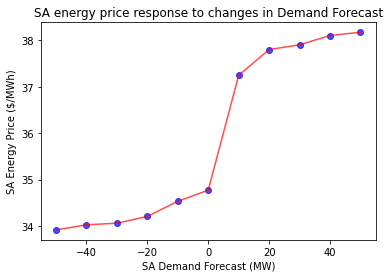

In [9]:
# Unzip for plotting
x, y = zip(*price_results)

# Plotting results
fig, ax = plt.subplots()
ax.plot(x, y,'o', alpha=0.7, color='b')
ax.plot(x, y,'-', alpha=0.7, color='r')
ax.set_title('SA energy price response to changes in Demand Forecast')
ax.set_xlabel('SA Demand Forecast (MW)')
ax.set_ylabel('SA Energy Price ($/MWh)')
plt.show()

The plot illustrates the range of `@DF` values over which the energy price in South Australia is unaffected, and also the `@DF` values which begin to alter prices. This type of analysis can help identify how sensitive prices are to changes in demand.

## Summary
This notebook outlines a workflow that can be used to perform sensitivity analyses. Relationships between other parameters and variables can be readily investigated, making the Dispatch API a flexibile tool that can facilitate a number of different studies. For instance, one may wish to know how prices or other system variables are impacted by a contingency such as sudden reduction in interconnector power flow limits, or the tripping of a generator.

While this tutorial has used historical data to perform an ex-post sensitivity analysis, the Dispatch API can also be used with customised case files. This lends the Dispatch API to a number of forecasting applications - user supplied forecasts for case file parameters could allow sensitivies to be computed in real time.